In [60]:
import numpy as np
import matplotlib.pyplot as plt

In [72]:
episodes = 100

In [73]:
class RandomAction:
    def __init__(self):
        self.reset()

    def reset(self):
        self.state = 2
        return self.state

    def step(self):
        action = np.random.choice([-1, 1])
        self.state += action
        if self.state < 0:
            return self.state, 0, True
        elif self.state > 4:
            return self.state, 1, True
        return self.state, 0, False

In [74]:
class MC:
    def __init__(self, alpha=0.1, do=False):
        self.alpha = alpha
        self.gamma = 1
        self.FIRST_VISIT = False

        self.V = np.zeros(5) + 0.5
        self.V_log = []

        if do:
            self.do()

    def do(self):
        self.V_log.append(self.V.copy())

        for episode in range(episodes):
            env = RandomAction()

            state = env.reset()
            done = False

            states = []
            rewards = []

            while not done:
                next_state, reward, done = env.step()
                states.append(state)
                rewards.append(reward)

                state = next_state

            G = 0
            for i in reversed(range(len(states))):
                if not self.FIRST_VISIT or states[i] not in states[:i]:
                    G = self.gamma * G + rewards[i]
                    self.V[states[i]] += self.alpha * (G - self.V[states[i]])

            self.V_log.append(self.V.copy())

In [75]:
class batch_TD:
    def __init__(self, alpha=0.1, do=False):
        self.alpha = alpha
        self.gamma = 1

        self.V = np.zeros(5) + 0.5
        self.V_log = []

        if do:
            self.do()

    def do(self):
        self.V_log.append(self.V.copy())

        for episode in range(episodes):
            env = RandomAction()

            state = env.reset()
            done = False

            V_delta = np.zeros(5)

            while not done:
                next_state, reward, done = env.step()
                if done:
                    V_delta[state] += reward - self.V[state]
                else:
                    V_delta[state] += reward + self.gamma * self.V[next_state] - self.V[state]
                state = next_state

            self.V += self.alpha * V_delta
            self.V_log.append(self.V.copy())

In [76]:
def RMS_RA(V):
    V = np.array(V)
    return np.sqrt(np.mean((V - np.array([1/6, 2/6, 3/6, 4/6, 5/6]))**2, axis=1))

In [83]:
MC_RMSs = []
TD_RMSs = []

TDss = []

for i in range(100):
    MC_alphas = [0.02]
    MCs = [MC(alpha=alpha, do=True) for alpha in MC_alphas]
    MC_RMS = [RMS_RA(mc.V_log) for mc in MCs]

    TD_alphas = [0.05]
    TDs = [batch_TD(alpha=alpha, do=True) for alpha in TD_alphas]
    TD_RMS = [RMS_RA(td.V_log) for td in TDs]

    MC_RMSs.append(MC_RMS)
    TD_RMSs.append(TD_RMS)
    TDss.append(TDs)

MC_RMSs_mean = np.mean(MC_RMSs, axis=0)
TD_RMSs_mean = np.mean(TD_RMSs, axis=0)

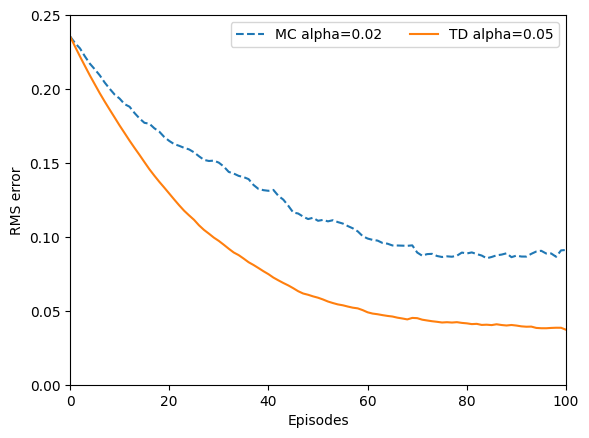

In [84]:
for i, alpha in enumerate(MC_alphas):
    plt.plot(MC_RMSs_mean[i], '--', label=f"MC alpha={alpha}")
for i, alpha in enumerate(TD_alphas):
    plt.plot(TD_RMSs_mean[i], label=f"TD alpha={alpha}")

plt.xlabel("Episodes")
plt.ylabel("RMS error")
plt.legend(ncol=2)
plt.xlim(0, episodes)
plt.ylim(0, 0.25)
plt.show()
